In [22]:
import cv2
import numpy as np
import os

# Modelling
from sklearn.metrics import confusion_matrix, accuracy_score,mean_absolute_error,accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(style='white')
%matplotlib inline

#PCA boyut indirgeme
from sklearn import decomposition

# Neural Network - Yapay Sinir Ağı
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras import optimizers

## Eğitim Verisinin Bölümlenmesi

In [3]:
DATADIR = "C:\\Users\\fbalt\\Desktop\\OruntuTanDeneme"
CATEGORIES = ["dog","cat","motorbike","carimages","ImagesPs"]
inputData = np.array([])
output = np.array([])

img_size=224

for category in CATEGORIES:
    classNum = CATEGORIES.index(category)
    out = np.zeros(1)
    out[0] = classNum
    path = os.path.join(DATADIR, category)
    for img in os.scandir(path):
        image = cv2.imread(os.path.join(path,img)) 
        newImg = cv2.resize(image,(img_size,img_size))
        inputData = np.append(inputData,newImg)
        output = np.append(output,out, axis=0)
        


inputData = np.reshape(inputData,(-1,img_size,img_size,3))
inputTrain = inputData.reshape(inputData.shape[0], -1)
outputTrain = np.squeeze(output.reshape(output.shape[0], -1).T)



In [5]:
print("Eğitim giriş verisi boyutları:{}".format(inputTrain.shape))
print("Eğitim çıkış verisi boyutları:{}".format(outputTrain.shape))

Eğitim giriş verisi boyutları:(3161, 150528)
Eğitim çıkış verisi boyutları:(3161,)


##  İki Boyutlu PCA Dönüşümü

In [6]:
inputTrain = decomposition.PCA(2).fit_transform(inputTrain)
print("PCA uygulanmış eğitim giriş verisi boyutları:{}".format(inputTrain.shape))

PCA uygulanmış eğitim giriş verisi boyutları:(3161, 2)


In [7]:
np.save("inputTrain",inputTrain)
np.save("outputTrain",outputTrain)

<function matplotlib.pyplot.show(*args, **kw)>

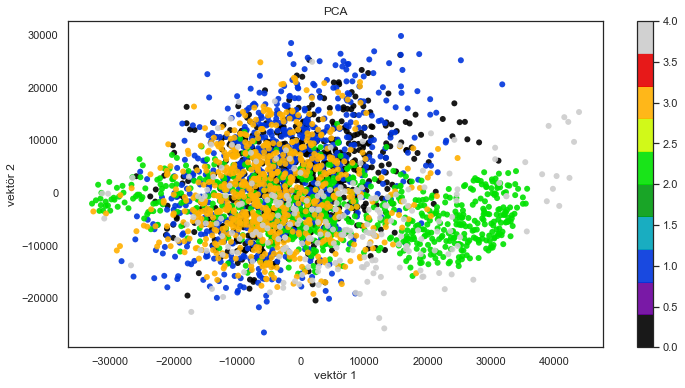

In [60]:
plt.figure(figsize=(12,6))
plt.scatter(inputTrain[:, 0],
inputTrain[:, 1], c=outputTrain,
edgecolor='none', alpha=0.9,
cmap=plt.cm.get_cmap('nipy_spectral',
10))
plt.xlabel('vektör 1')
plt.ylabel('vektör 2')
plt.title('PCA')
plt.colorbar()
plt.show

## Test Verisinin Bölümlenmesi

In [124]:
DATADIR = "C:\\Users\\fbalt\\Desktop\\OruntuTanDeneme\\testImages"
CATEGORIES = ["testDog","testCat","testMotorbike","testCar","testPs"]
splitInput = np.array([])
splitOutput = np.array([])
img_size=224


for category in CATEGORIES:
    classNum = CATEGORIES.index(category)
    out = np.zeros(1)
    out[0]= classNum
    path = os.path.join(DATADIR, category)
    for img in os.scandir(path):
        image = cv2.imread(os.path.join(path,img)) 
        newImg = cv2.resize(image,(img_size,img_size))
        splitInput = np.append(splitInput,newImg)
        splitOutput = np.append(splitOutput,out, axis=0)
        
        
splitInput = np.reshape(splitInput,(-1,img_size,img_size,3))
inputTest = splitInput.reshape(splitInput.shape[0], -1)
outputTest = np.squeeze(splitOutput.reshape(splitOutput.shape[0], -1).T)

In [125]:
print("Test giriş verisi boyutları:{}".format(inputTest.shape))
print("Test çıkış verisi boyutları:{}".format(outputTest.shape))

Test giriş verisi boyutları:(547, 150528)
Test çıkış verisi boyutları:(547,)


In [122]:
inputTest = decomposition.PCA(2).fit_transform(inputTest)
print("PCA uygulanmış test giriş verisi boyutları:{}".format(inputTest.shape))

PCA uygulanmış test giriş verisi boyutları:(547, 2)


In [123]:
np.save("inputTest",inputTest)
np.save("outputTest",outputTest)

<function matplotlib.pyplot.show(*args, **kw)>

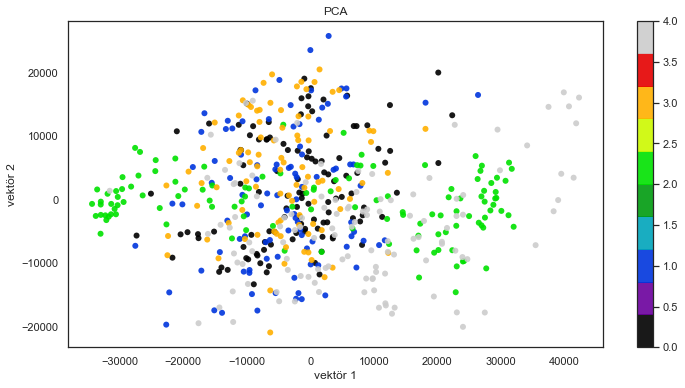

In [63]:
plt.figure(figsize=(12,6))
plt.scatter(inputTest[:, 0],
inputTest[:, 1], c=outputTest,
edgecolor='none', alpha=0.9,
cmap=plt.cm.get_cmap('nipy_spectral',
10))
plt.xlabel('vektör 1')
plt.ylabel('vektör 2')
plt.title('PCA')
plt.colorbar()
plt.show

## Naif Bayes

In [40]:
gauss = GaussianNB().fit(inputTrain,outputTrain)
pred_gauss_train = gauss.predict(inputTrain)
pred_gauss_test = gauss.predict(inputTest)

# Train accuracy
gauss_train_accr = round(gauss.score(inputTrain,outputTrain) * 100, 2)
gauss_test_accr = round(gauss.score(inputTest,outputTest) * 100, 2)

# Error rate
gauss_train_mae = round((mean_absolute_error(outputTrain, pred_gauss_train) * 100), 2)
gauss_test_mae = round((mean_absolute_error(outputTest, pred_gauss_test) * 100), 2)



## Naif Bayes Sonuçları

In [57]:
print("Gauss-Eğitim dogruluk oranı : %{}".format(gauss_train_accr))
print("Gauss-Test dogruluk oranı : %{}".format(gauss_test_accr))

Gauss-Eğitim dogruluk oranı : %41.0
Gauss-Test dogruluk oranı : %35.1


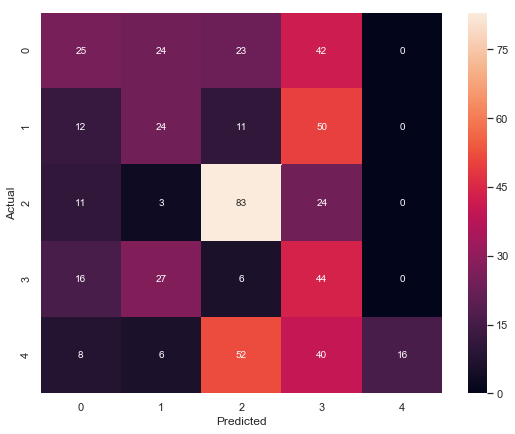

In [110]:
conf_mat = confusion_matrix(outputTest, pred_gauss_test)
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## K-En Yakın Komşular

In [86]:
trainAcc = []
testAcc = []
for i in range(1, 20): 
    knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': [i]}, iid=False, cv=10)
    knn = knn.fit(inputTrain, outputTrain)
    pred_knn_train = knn.predict(inputTrain)
    pred_knn_test = knn.predict(inputTest)
    
    knn_train_accr = round(knn.score(inputTrain,outputTrain) * 100, 2)
    knn_test_accr = round(knn.score(inputTest,outputTest) * 100, 2)
    
    trainAcc.append(knn_train_accr)
    testAcc.append(knn_test_accr)   
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

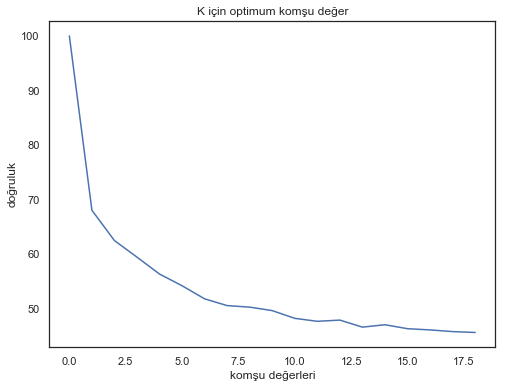

In [103]:
plt.figure(figsize=(8,6))
plt.plot(trainAcc)
plt.title('K için optimum komşu değer')
plt.ylabel('doğruluk')
plt.xlabel('komşu değerleri')
plt.show()


In [89]:
knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': [2]}, iid=False, cv=10)
knn = knn.fit(inputTrain, outputTrain)

pred_knn_train = knn.predict(inputTrain)
pred_knn_test = knn.predict(inputTest)


# Train accuracy
knn_train_accr = round(knn.score(inputTrain,outputTrain) * 100, 2)
knn_test_accr = round(knn.score(inputTest,outputTest) * 100, 2)
# Error rate
knn_train_mae = round((mean_absolute_error(outputTrain, pred_knn_train) * 100), 2)
knn_test_mae = round((mean_absolute_error(outputTest, pred_knn_test) * 100), 2)

## K-En Yakın Komşular Sonuçları

In [90]:
print("Knn-Eğitim dogruluk oranı : %{}".format(knn_train_accr))
print("Knn-Test dogruluk oranı : %{}".format(knn_test_accr))

Knn-Eğitim dogruluk oranı : %68.02
Knn-Test dogruluk oranı : %38.03


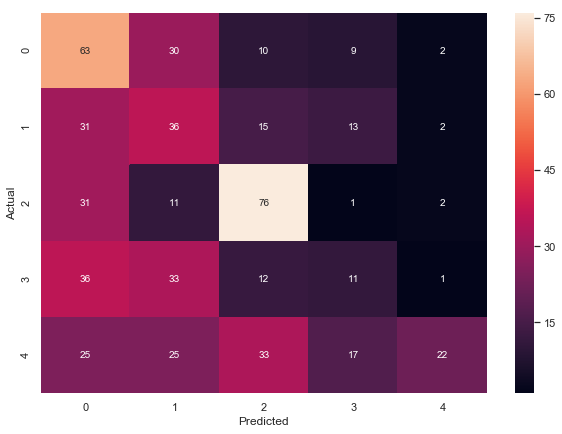

In [111]:
conf_mat = confusion_matrix(outputTest, pred_knn_test)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<h3>3.6. Destek Vektör Makineleri (Support Vector Machines)</h3>

In [114]:
# Tahminleme
svc = SVC().fit(inputTrain,outputTrain)
pred_svc_train = svc.predict(inputTrain)
pred_svc_test = svc.predict(inputTest)

# Eğitim seti doğruluğu
svc_train_accr = round(svc.score(inputTrain,outputTrain) * 100, 2)
svc_test_accr = round(svc.score(inputTest,outputTest) * 100, 2)

# Eğitim seti hata oranı
svc_train_mae = round((mean_absolute_error(outputTrain, pred_svc_train) * 100), 2)
svc_test_mae = round((mean_absolute_error(outputTest, pred_svc_test) * 100), 2)


C:\Users\fbalt\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [115]:
print("Destek Vektör Makineleri-Eğitim dogruluk oranı : %{}".format(svc_train_accr))
print("Destek Vektör Makineleri-Test dogruluk oranı : %{}".format(svc_test_accr))


Destek Vektör Makineleri-Eğitim dogruluk oranı : %100.0
Destek Vektör Makineleri-Test dogruluk oranı : %22.49


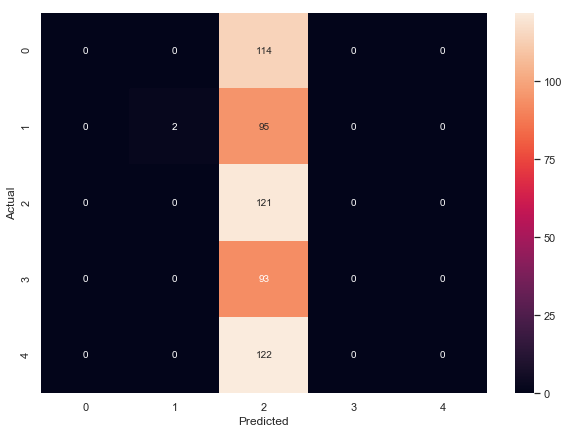

In [119]:
conf_mat = confusion_matrix(outputTest, pred_svc_test)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Logistic


In [48]:
# Tahminleme
logreg = LogisticRegression().fit(inputTrain, outputTrain)
pred_logreg_train = logreg.predict(inputTrain)
pred_logreg_test = logreg.predict(inputTest)

# Eğitim seti doğruluğu
logreg_train_accr = round(logreg.score(inputTrain,outputTrain) * 100, 2)
logreg_test_accr = round(logreg.score(inputTest,outputTest) * 100, 2)

# Eğitim seti hata oranı
logreg_train_mae = round((mean_absolute_error(outputTrain, pred_logreg_train) * 100), 2)
logreg_test_mae = round((mean_absolute_error(outputTest, pred_logreg_test) * 100), 2)


C:\Users\fbalt\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fbalt\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [49]:
print("Lojistik Regresyon-Eğitim dogruluk oranı : %{}".format(logreg_train_accr))
print("Lojistik Regresyon-Test dogruluk oranı : %{}".format(logreg_test_accr))

Lojistik Regresyon-Eğitim dogruluk oranı : %36.03
Lojistik Regresyon-Test dogruluk oranı : %23.03


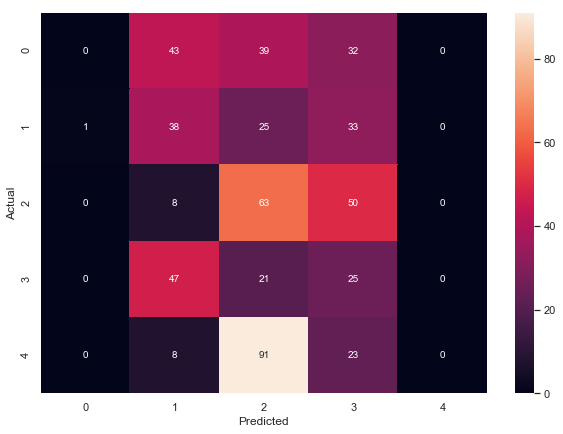

In [120]:
conf_mat = confusion_matrix(outputTest, pred_logreg_test)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Yapay Sinir Ağı

In [44]:
def build_ann(optimizer='adam',activationFunc='relu'):
    
    ann = Sequential()
    
    # Giriş ve gizli katmanın oluşturulması
    ann.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(len(inputTrain[1]),)))
    
    # Diğer katmanların eklenmesi
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation=activationFunc))
    ann.add(Dropout(rate=0.5))
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation=activationFunc))
    ann.add(Dropout(rate=0.5))
    
    # Çıkış katmanının eklenmesi
    ann.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    
    ann.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return ann

In [45]:
# Yapay sinir ağının oluşturulması
opt = optimizers.Adam(lr=0.01)
ann = build_ann(opt,'relu')

# Yapay sinir ağının eğitilmesi
history = ann.fit(inputTrain, outputTrain, batch_size=16, epochs=100, validation_data=(inputTest, outputTest))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 3161 samples, validate on 547 samples
Epoch 1/100
3161/3161 [==============================] - 10s 3ms/step - loss: -9.2656 - acc: 0.2370 - val_loss: -16.2921 - val_acc: 0.1773
Epoch 2/100
3161/3161 [==============================] - 1s 327us/step - loss: -11.5544 - acc: 0.2351 - val_loss: -16.2921 - val_acc: 0.1773
Epoch 3/100
3161/3161 [==============================] - 1s 330us/step - loss: -11.4783 - acc: 0.2351 - val_loss: -16.2921 - val_acc: 0.1773
Epoch 4/100
3161/3161 [==============================] - 1s 332us/step - loss: -11.5138 - acc: 0.2357 - val_loss: -16.2921 - val_acc: 0.1773
Epoch 5/100
3161/3161 [==============================] - 1s 326us/step - loss: -9.4260 - acc: 0.2341 - val_loss: -16.2921 - val_acc: 0.1773
Epoch 6/100
3161/3161 [==============================] - 1s 341us/step - loss: -11.2750 

Epoch 54/100
3161/3161 [==============================] - 2s 482us/step - loss: -11.5696 - acc: 0.2351 - val_loss: -16.2921 - val_acc: 0.1773
Epoch 55/100
3161/3161 [==============================] - 1s 348us/step - loss: -11.5341 - acc: 0.2354 - val_loss: -16.2921 - val_acc: 0.1773
Epoch 56/100
3161/3161 [==============================] - 1s 359us/step - loss: -11.5747 - acc: 0.2354 - val_loss: -16.2921 - val_acc: 0.1773
Epoch 57/100
3161/3161 [==============================] - 1s 388us/step - loss: -11.5595 - acc: 0.2354 - val_loss: -16.2921 - val_acc: 0.1773
Epoch 58/100
3161/3161 [==============================] - 1s 348us/step - loss: -11.5747 - acc: 0.2354 - val_loss: -16.2921 - val_acc: 0.1773
Epoch 59/100
3161/3161 [==============================] - 1s 404us/step - loss: -11.5747 - acc: 0.2354 - val_loss: -16.2921 - val_acc: 0.1773
Epoch 60/100
3161/3161 [==============================] - 1s 401us/step - loss: -11.5747 - acc: 0.2354 - val_loss: -16.2921 - val_acc: 0.1773
Epoch 

In [46]:
# Eğitim seti tahminleme
pred_ann_train = ann.predict(inputTrain)
pred_ann_train = (pred_ann_train > 0.5) * 1

# Test seti tahminleme
pred_ann_test = ann.predict(inputTest)
pred_ann_test = (pred_ann_test > 0.5) * 1

# Eğitim seti doğruluğu
ann_train_accr = round(accuracy_score(outputTrain,pred_ann_train) * 100, 2)
ann_test_accr = round(accuracy_score(outputTest,pred_ann_test) * 100, 2)

In [47]:
print("Neural Network eğitim doğruluğu: %{}".format(ann_train_accr))
print("Neural Network test doğruluğu: %{}".format(ann_test_accr))

Neural Network eğitim doğruluğu: %23.54
Neural Network test doğruluğu: %17.73
